### Plot evolution of TNG and Chempy

In [1]:
%pylab inline
# Import solar abundances
import os
FS=16
os.chdir('/home/oliverphilcox/ChempyMulti/')
tng=np.load("/mnt/store1/oliverphilcox/ChempyMultiData/TNG/TNG_Mock_Data_Full_v4.npz")

Populating the interactive namespace from numpy and matplotlib


## TNG only plot (see main plot below)

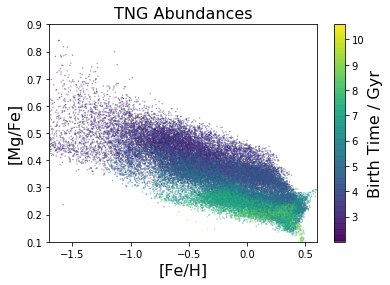

In [2]:
MgFeTNG=tng.f.true_abuns[:,3]
HeFeTNG=tng.f.true_abuns[:,2]
FeHTNG=tng.f.true_abuns[:,1]
timesTNG=tng.f.true_time
massesTNG = tng.f.particle_masses
plt.scatter(FeHTNG,MgFeTNG,alpha=0.8,s=0.1,c=timesTNG)
cb=plt.colorbar();
cb.set_label('Birth Time / Gyr',fontsize=FS)
plt.ylabel(r'[Mg/Fe]',fontsize=FS);plt.xlabel(r'[Fe/H]',fontsize=FS);
plt.title('TNG Abundances',fontsize=FS);
plt.xlim([-1.7,0.6]);plt.ylim([0.1,0.9]);

## Draw Chempy times from the SFR

In [3]:
from scipy.special import gamma
SFR_peak=10.**0.55
def SFR(t,k=2,theta=SFR_peak):
    return 1./(gamma(k)*theta**k)*t**(k-1)*np.exp(-t/theta)

t_grid = np.linspace(1.,13.8,100000)
sfr_grid = SFR(t_grid)/np.sum(SFR(t_grid))
t_samples = np.random.choice(t_grid,size=10000,p=sfr_grid)

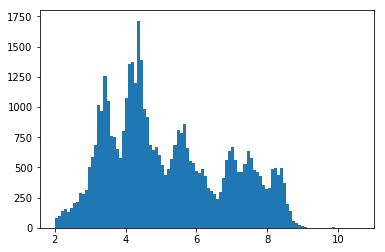

In [5]:
plt.hist(timesTNG,bins=100);

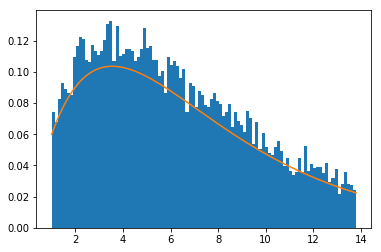

In [6]:
plt.hist(t_samples,density=True,bins=100)
plt.plot(t_grid,SFR(t_grid))

### Make some Chempy data:

In [26]:
from Chempy.parameter import ModelParameters
a=ModelParameters()
import multiprocessing as mp
import numpy as np
import tqdm, time
from scipy.stats import norm,uniform
from Chempy.cem_function import single_timestep_chempy

N_samples = 1000

sampled_tng_times = np.random.choice(timesTNG[timesTNG>1.],size=N_samples,replace=True,p=massesTNG/np.sum(massesTNG))
widths = np.asarray([0.,0.,0.3,0.1,0.1,0.3])#,0.1,0.])
priors = [-2.3,-2.89,-0.3,0.55,0.5,0.5]#,1.5,0.]
all_params=np.zeros([N_samples,len(priors)+1])
for i in range(len(all_params)):
    while all_params[i,3]<0.29402: # to avoid SFR errors
        all_params[i,:-1]=norm.rvs(loc=priors,scale=widths)
    all_params[i,-1]=sampled_tng_times[i]#uniform.rvs(loc=1.0,scale=12.8)
print("Created %d-element parameter set."%N_samples)

def runner(index):
    """Function to compute the Chempy predictions for each parameter set"""
    b=ModelParameters()
    params=all_params[index]
    output=single_timestep_chempy((params,b))
    if type(output)==float:
        if output==np.inf:
            del b
        outs=np.zeros(len(els)),params
    else: 
        abun=output[0]
        del b;
        outs=abun,params
    return outs

init_time=time.time()
    
# Compute elements by running code once:
output=single_timestep_chempy((list(priors)+[10.],a))
if output==np.inf:
    raise Exception("Bad SFR input even for prior parameters - check for bugs")
else:
    _,els=output

# Now run multiprocessing
cpus=mp.cpu_count()
p=mp.Pool(min(16,cpus))
output=list(tqdm.tqdm(p.imap_unordered(runner,range(N_samples)),total=N_samples))
abuns=[o[0] for o in output]
pars=[o[1] for o in output]

end_time=time.time()

print("multiprocessing complete after %d seconds"%(end_time-init_time));


Created 1000-element parameter set.


100%|██████████| 1000/1000 [00:43<00:00, 22.75it/s]

multiprocessing complete after 44 seconds


In [8]:
# from Chempy.parameter import ModelParameters
# a=ModelParameters()
# import multiprocessing as mp
# import numpy as np
# import tqdm, time
# from scipy.stats import norm,uniform
# from Chempy.cem_function import single_timestep_chempy

# N_samples = 100

# sampled_tng_times = np.random.choice(timesTNG[timesTNG>1.],size=N_samples,replace=False,p=massesTNG/np.sum(massesTNG))
# widths = np.asarray([0.,0.,0.3,0.1,0.1,0.3])#,0.1,0.])
# priors = [-2.3,-2.89,-0.3,0.55,0.5,0.5]#,1.5,0.]
# all_abuns=[]
# all_pars=[]

# for ind in range(5):
#     all_params=np.zeros([N_samples,len(priors)+1])
#     for i in range(len(all_params)):
#         all_params[i,:-1]=priors
#         all_params[i,-1]=sampled_tng_times[i]

#     if ind==1:
#         all_params[:,2]-=2.*widths[2] # low SFE
#     if ind==2:
#         all_params[:,3]-=2.*widths[3] # bursty SFR
#     if ind==3:
#         all_params[:,4]+=2.*widths[4] # leaky ISM
#     if ind==4:
#         all_params[:,5]+=2.*widths[5] # big corona
    
#     def runner(index):
#         """Function to compute the Chempy predictions for each parameter set"""
#         b=ModelParameters()
#         params=all_params[index]
#         output=single_timestep_chempy((params,b))
#         if type(output)==float:
#             if output==np.inf:
#                 del b
#             outs=np.zeros(len(els)),params
#         else: 
#             abun=output[0]
#             del b;
#             outs=abun,params
#         return outs

#     # Compute elements by running code once:
#     output=single_timestep_chempy((list(priors)+[10.],a))
#     if output==np.inf:
#         raise Exception("Bad SFR input even for prior parameters - check for bugs")
#     else:
#         _,els=output

#     # Now run multiprocessing
#     cpus=mp.cpu_count()
#     p=mp.Pool(min(16,cpus))
#     output=list(tqdm.tqdm(p.imap_unordered(runner,range(N_samples)),total=N_samples))
#     abuns=[o[0] for o in output]
#     pars=[o[1] for o in output]
#     all_abuns.append(abuns)
#     all_pars.append(pars)

100%|██████████| 100/100 [00:04<00:00, 13.40it/s]


In [27]:
from Chempy.cem_function import single_timestep_chempy
b=ModelParameters()
params=list(b.p0)+[1.]
out=single_timestep_chempy((params,b))
del b
b=ModelParameters()
params2=list(b.p0)+[1.6]
out2=single_timestep_chempy((params2,b))

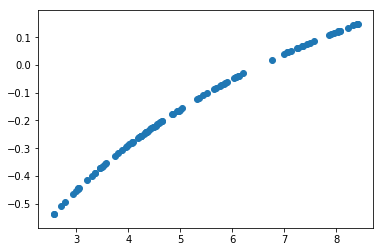

In [28]:
timesChempy = np.asarray(all_pars[0])[:,-1]
FeHChempy = np.asarray(all_abuns[0])[:,1]
sort_ind = np.argsort(timesChempy)
#plt.plot(timesChempy[sort_ind])
plt.scatter(timesChempy[sort_ind],FeHChempy[sort_ind])
#plt.xlim([9,10])

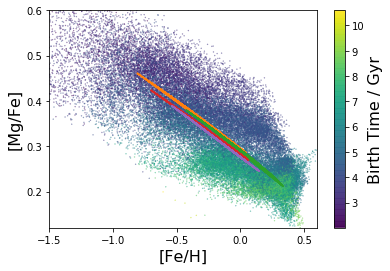

In [29]:
plt.scatter(FeHTNG,MgFeTNG,alpha=0.8,s=0.1,c=timesTNG)
cb=plt.colorbar();
#plt.scatter(FeHChempy,MgFeChempy,alpha=0.94,s=0.1,c=timesChempy)
from corner import hist2d as cohist
#cohist(FeHChempy,MgFeChempy,bins=100,smooth=2.,no_fill_contours=True,plot_datapoints=False,
#       contour_kwargs={'alpha':0.6},plot_density=False)
#cohist(FeHTNG,MgFeTNG,bins=100,smooth=2.,no_fill_contours=True,plot_datapoints=False,
#contour_kwargs={'alpha':.6,'linestyles':'-','colors':'r'},plot_density=False)
for ind in range(5):
    abuns = np.asarray(all_abuns[ind])
    timesChempy=np.asarray(all_pars[0])[:,-1]
    sort_ind = np.argsort(timesChempy)
    MgFeChempy=abuns[sort_ind,4]
    HeFeChempy=abuns[sort_ind,3]#[:,4]
    FeHChempy=abuns[sort_ind,1]
    plt.plot(FeHChempy,MgFeChempy)#,s=3)#,c=timesChempy[sort_ind])

cb.set_label('Birth Time / Gyr',fontsize=FS)
plt.ylabel(r'[Mg/Fe]',fontsize=FS);plt.xlabel(r'[Fe/H]',fontsize=FS);
#plt.title('Chempy vs TNG Abundances',fontsize=FS);
plt.xlim([-1.5,0.6]);plt.ylim([0.12,0.6]);
#plt.savefig('/home/oliverphilcox/ChempyMulti/Plots2/TNG_Chempy_Comparison.pdf',bbox_inches='tight')
#plt.xlim([-1.1,0.6]);plt.ylim([0.1,0.5]);
#plt.xlim([-0.35,-0.21]);plt.ylim([0.2,0.4]);

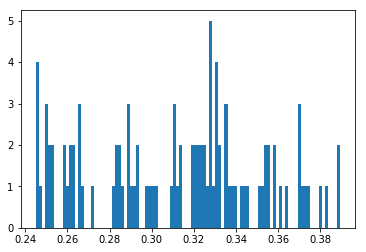

In [30]:
plt.hist(np.asarray(all_abuns[0])[:,4],bins=100);

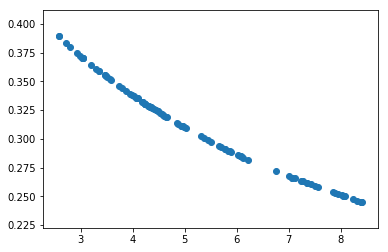

In [31]:
plt.scatter(np.asarray(all_pars[0])[:,-1],np.asarray(all_abuns[0])[:,4])

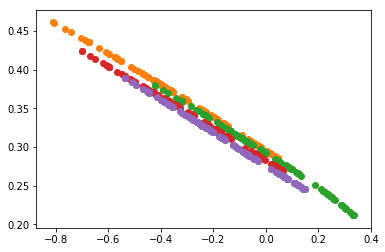

In [32]:
for ind in range(5):
    plt.scatter(np.asarray(all_abuns[ind])[:,1],np.asarray(all_abuns[ind])[:,4])

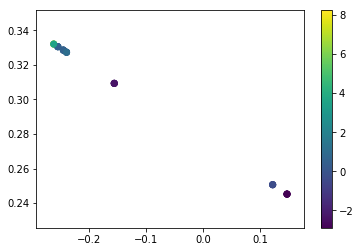

In [33]:
abuns = np.asarray(all_abuns[0])
timesChempy=np.asarray(all_pars)[:,-1]
sort_ind = np.argsort(timesChempy)
sort_times = np.sort(timesChempy)
MgFeChempy=abuns[sort_ind,4]
HeFeChempy=abuns[sort_ind,3]#[:,4]
FeHChempy=abuns[sort_ind,1]
plt.scatter(FeHChempy,MgFeChempy,c=timesChempy)
plt.colorbar()

(array([ 26.,  94., 160., 211., 114., 100.,  66., 116.,  67.,  46.]),
 array([2.0052972 , 2.69910361, 3.39291001, 4.08671641, 4.78052282,
        5.47432922, 6.16813563, 6.86194203, 7.55574844, 8.24955484,
        8.94336124]),
 <a list of 10 Patch objects>)

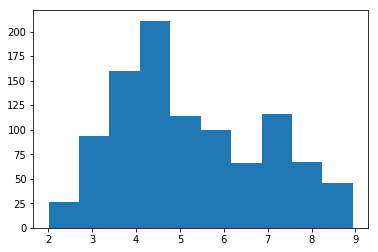

In [34]:
plt.hist(sampled_tng_times,bins=10)

(array([5., 3., 4., 0., 2., 3., 2., 4., 0., 1., 0., 0., 1., 4., 1., 4., 3.,
        0., 2., 2., 0., 0., 4., 3., 0., 2., 4., 4., 6., 5., 2., 4., 2., 1.,
        2., 0., 1., 3., 2., 2., 1., 1., 0., 4., 2., 0., 1., 1., 0., 2.]),
 array([0.24495322, 0.2478428 , 0.25073238, 0.25362196, 0.25651153,
        0.25940111, 0.26229069, 0.26518027, 0.26806985, 0.27095943,
        0.273849  , 0.27673858, 0.27962816, 0.28251774, 0.28540732,
        0.28829689, 0.29118647, 0.29407605, 0.29696563, 0.29985521,
        0.30274478, 0.30563436, 0.30852394, 0.31141352, 0.3143031 ,
        0.31719267, 0.32008225, 0.32297183, 0.32586141, 0.32875099,
        0.33164056, 0.33453014, 0.33741972, 0.3403093 , 0.34319888,
        0.34608846, 0.34897803, 0.35186761, 0.35475719, 0.35764677,
        0.36053635, 0.36342592, 0.3663155 , 0.36920508, 0.37209466,
        0.37498424, 0.37787381, 0.38076339, 0.38365297, 0.38654255,
        0.38943213]),
 <a list of 50 Patch objects>)

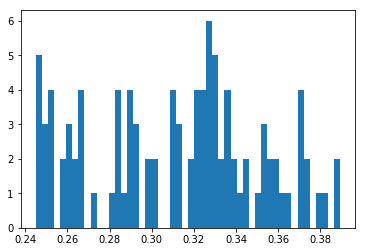

In [35]:
plt.hist(np.asarray(all_abuns[4])[:,4],bins=50)

(array([4.51675984e-02, 2.03421863e-01, 2.86921301e-01, 1.60292094e-01,
        1.56113253e-01, 1.10661906e-01, 1.21470143e-01, 7.85725327e-02,
        1.05760796e-03, 1.28976580e-04]),
 array([ 2.00176861,  2.86101741,  3.7202662 ,  4.579515  ,  5.4387638 ,
         6.29801259,  7.15726139,  8.01651018,  8.87575898,  9.73500778,
        10.59425657]),
 <a list of 10 Patch objects>)

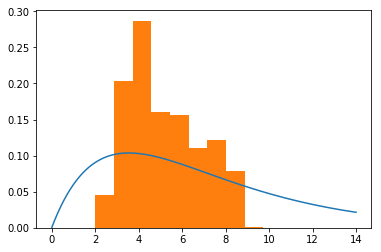

In [36]:
from scipy.special import gamma
def sfr(t,theta,k=2.):
    return t**(k-1.)/(gamma(k)*theta**k)*np.exp(-t/theta)
ts = np.linspace(0,14,100)
plt.plot(ts,sfr(ts,a.sfr_scale))
plt.hist(timesTNG,density=True)

# Main Plot

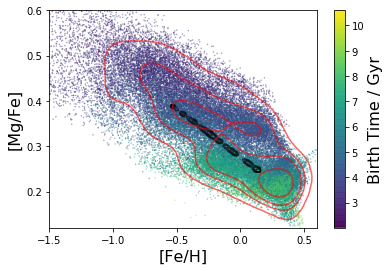

In [37]:
abuns = np.asarray(abuns)
pars = np.asarray(pars)
MgFeChempy=abuns[:,4]
HeFeChempy=abuns[:,3]#[:,4]
FeHChempy=abuns[:,1]
timesChempy=pars[:,-1]
plt.scatter(FeHTNG,MgFeTNG,alpha=0.8,s=0.1,c=timesTNG)
#plt.scatter(FeHChempy,MgFeChempy,alpha=0.94,s=0.1,c=timesChempy)
from corner import hist2d as cohist
cohist(FeHChempy,MgFeChempy,bins=100,smooth=2.,no_fill_contours=True,plot_datapoints=False,
       contour_kwargs={'alpha':0.6},plot_density=False)
cohist(FeHTNG,MgFeTNG,bins=100,smooth=2.,no_fill_contours=True,plot_datapoints=False,
       contour_kwargs={'alpha':.6,'linestyles':'-','colors':'r'},plot_density=False)
cb=plt.colorbar();
cb.set_label('Birth Time / Gyr',fontsize=FS)
plt.ylabel(r'[Mg/Fe]',fontsize=FS);plt.xlabel(r'[Fe/H]',fontsize=FS);
#plt.title('Chempy vs TNG Abundances',fontsize=FS);
plt.xlim([-1.5,0.6]);plt.ylim([0.12,0.6]);
#plt.savefig('/home/oliverphilcox/ChempyMulti/Plots2/TNG_Chempy_Comparison.pdf',bbox_inches='tight')
#plt.xlim([-1.1,0.6]);plt.ylim([0.1,0.5]);
#plt.xlim([-0.35,-0.21]);plt.ylim([0.2,0.4]);

Plot abundances vs age

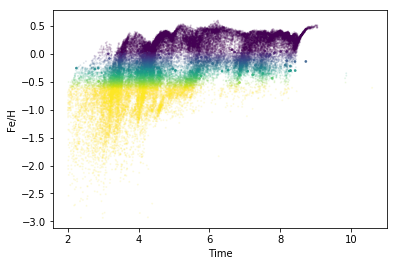

In [37]:
plt.scatter(timesTNG,FeHTNG,c=HeFeTNG,s=1,alpha=0.1)
min_, max_ = HeFeChempy.min(),HeFeChempy.max()
plt.clim([min_,max_])
plt.scatter(timesChempy,FeHChempy,c=HeFeChempy,alpha=0.8,s=3);
plt.clim([min_,max_])
#plt.ylim([-2,1.]);plt.colorbar();
plt.xlabel('Time');plt.ylabel('Fe/H');

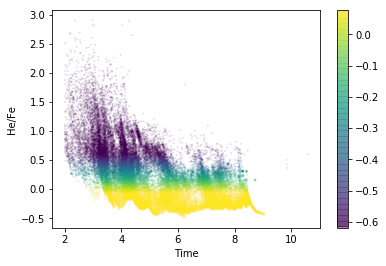

In [38]:
plt.scatter(timesTNG,HeFeTNG,c=FeHTNG,s=1,alpha=0.1)
min_, max_ = FeHChempy.min(),FeHChempy.max()
plt.clim([min_,max_])
plt.scatter(timesChempy,HeFeChempy,c=FeHChempy,s=3,alpha=0.5);
plt.clim([min_,max_])
#plt.ylim([-2,1.]);
plt.colorbar();
plt.xlabel('Time');plt.ylabel('He/Fe');

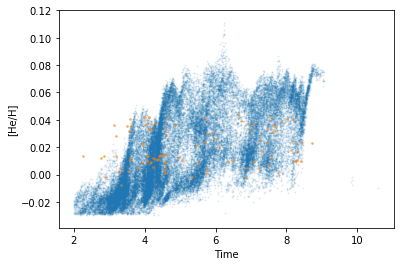

In [40]:
plt.scatter(timesTNG,HeFeTNG+FeHTNG,s=1,alpha=0.1)
plt.scatter(timesChempy,HeFeChempy+FeHChempy,s=3,alpha=0.5);
#plt.ylim([-2,1.]);
plt.xlabel('Time');plt.ylabel('[He/H]');

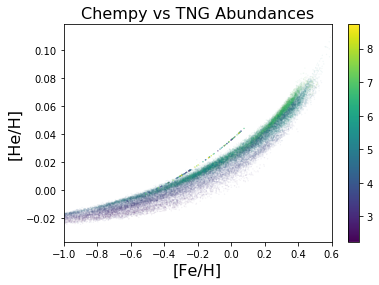

In [41]:
plt.scatter(FeHTNG,FeHTNG+HeFeTNG,alpha=0.08,s=0.1,c=timesTNG)
plt.scatter(FeHChempy,FeHChempy+HeFeChempy,alpha=0.94,s=0.1,c=timesChempy)
from corner import hist2d as cohist
#cohist(FeHChempy,MgFeChempy,bins=100,smooth=2.,no_fill_contours=True,plot_datapoints=False,
#       contour_kwargs={'alpha':0.5},plot_density=False)
#cohist(FeHTNG,MgFeTNG,bins=100,smooth=2.,no_fill_contours=True,plot_datapoints=False,
#       contour_kwargs={'alpha':0.5,'linestyles':'--','colors':'r'},plot_density=False)
cb=plt.colorbar();
#cb.set_label('Birth Time / Gyr',fontsize=FS)
plt.ylabel(r'[He/H]',fontsize=FS);plt.xlabel(r'[Fe/H]',fontsize=FS);
plt.title('Chempy vs TNG Abundances',fontsize=FS);
plt.xlim([-1,0.6]);
#plt.xlim([-1.1,0.6]);plt.ylim([0.1,0.5]);
#plt.xlim([-0.35,-0.21]);plt.ylim([0.2,0.4]);

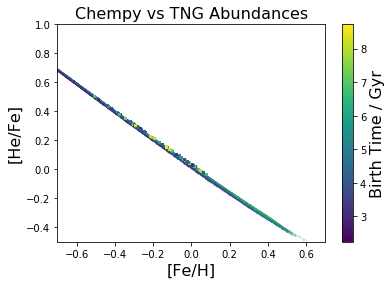

In [42]:
plt.scatter(FeHTNG,HeFeTNG,alpha=0.4,s=0.1,c=timesTNG)
plt.scatter(FeHChempy,HeFeChempy,alpha=0.94,s=4,marker='s',c=timesChempy)
from corner import hist2d as cohist
#cohist(FeHChempy,MgFeChempy,bins=100,smooth=2.,no_fill_contours=True,plot_datapoints=False,
#       contour_kwargs={'alpha':0.5},plot_density=False)
#cohist(FeHTNG,MgFeTNG,bins=100,smooth=2.,no_fill_contours=True,plot_datapoints=False,
#       contour_kwargs={'alpha':0.5,'linestyles':'--','colors':'r'},plot_density=False)
cb=plt.colorbar();
cb.set_label('Birth Time / Gyr',fontsize=FS)
plt.ylabel(r'[He/Fe]',fontsize=FS);plt.xlabel(r'[Fe/H]',fontsize=FS);
plt.title('Chempy vs TNG Abundances',fontsize=FS);
plt.xlim([-0.7,0.7]);plt.ylim([-0.5,1]);
#plt.xlim([-1.1,0.6]);plt.ylim([0.1,0.5]);
#plt.xlim([-0.35,-0.21]);plt.ylim([0.2,0.4]);

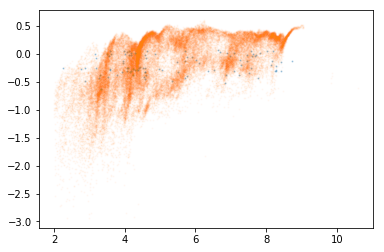

In [43]:
plt.scatter(timesChempy,FeHChempy,alpha=0.3,s=1)
plt.scatter(timesTNG,FeHTNG,alpha=0.03,s=1)

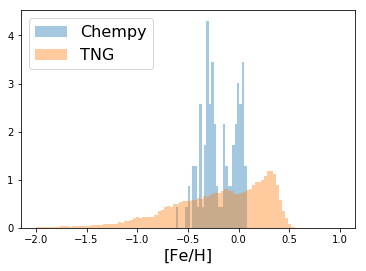

In [44]:
plt.hist(FeHChempy,alpha=0.4,density=True,bins=30,label='Chempy')
plt.hist(FeHTNG,alpha=0.4,density=True,bins=100,range=[-2,1],label='TNG');
plt.xlabel('[Fe/H]',fontsize=FS);plt.legend(fontsize=FS);

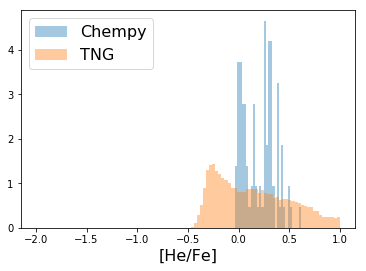

In [45]:
HeFeChempy=abuns[:,3]
plt.hist(HeFeChempy,alpha=0.4,density=True,bins=30,label='Chempy')
plt.hist(HeFeTNG,alpha=0.4,density=True,bins=100,range=[-2,1],label='TNG');
plt.xlabel('[He/Fe]',fontsize=FS);plt.legend(fontsize=FS);

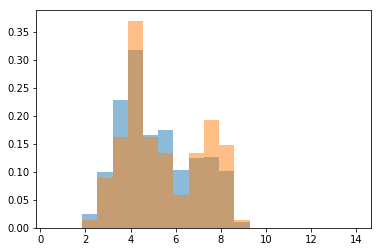

In [47]:
plt.hist(timesTNG,density=True,range=[0.5,14],bins=20,alpha=0.5);
plt.hist(timesChempy,density=True,range=[0.5,14],bins=20,alpha=0.5);

## Check HDF5 files

In [ ]:
import h5py
file=h5py.File('Chempy/input/yields/TNG/SNIa.hdf5')
list(file.keys())

In [ ]:
np.sum(file['Yield'].value)

In [58]:
import h5py
file=h5py.File('Chempy/input/yields/TNG/AGB.hdf5')
list(file.keys())

file['Metallicities'].value

x=file['Yields']['Z_0.02']['Yield']

yields=file['Yields/Z_0.02/Yield'].value

In [59]:
list(file.keys())

['Masses',
 'Metallicities',
 'Number_of_masses',
 'Number_of_metallicities',
 'Number_of_species',
 'Reference',
 'Species_names',
 'Yield_names',
 'Yields']

In [60]:
file['Yields/Z_0.02']['Ejected_mass'].value

array([0.43600038, 0.67599964, 0.90000063, 1.1350001 , 1.2699991 ,
       1.3600004 , 1.5899984 , 1.837     , 2.3179984 , 2.7819986 ,
       3.2079964 , 3.647999  , 4.1210012 , 4.6000032 , 5.0710044 ,
       4.49      , 4.85      ], dtype=float32)

In [61]:
file.close()

## Create Plot of TNG yields to compare to TNG

In [ ]:
# Load solar abundances
from Chempy.solar_abundance import solar_abundances
basic_solar = solar_abundances()
getattr(basic_solar, 'Asplund09')()

# Initialise the SSP class with time-steps

time_steps = np.linspace(0.,13.5,521)

# Load the default yields

from Chempy.yields import SN2_feedback, AGB_feedback, SN1a_feedback
basic_sn2 = SN2_feedback()
getattr(basic_sn2, 'TNG_net')()
basic_1a = SN1a_feedback()
getattr(basic_1a, "TNG")()
basic_agb = AGB_feedback()
getattr(basic_agb, "TNG_net")()

# Use all elements that are traced
elements_to_trace = els

# Producing the SSP birth elemental fractions (here we use solar)

solar_fractions = []
elements = np.hstack(basic_solar.all_elements)
for item in elements_to_trace:
    solar_fractions.append(float(basic_solar.fractions[np.where(elements==item)]))

list_of_metallicities = [0.02]#np.logspace(-4,-2,2)
list_of_SSP_tables = []
list_of_SSP_tables.append(list_of_metallicities)
list_of_SSP_tables.append(time_steps)

from Chempy.wrapper import SSP_wrap

In [ ]:
basic_ssp = SSP_wrap(a)
basic_ssp.calculate_feedback(0.02,list(elements_to_trace),list(solar_fractions),np.copy(time_steps))

In [ ]:
agbs,sn1as,sn2s=[],[],[]
for el in els:
    agbs.append(np.sum(basic_ssp.agb_table[el][:343]))
    sn1as.append(np.sum(basic_ssp.sn1a_table[el][:343]))
    sn2s.append(np.sum(basic_ssp.sn2_table[el][:343]))

In [ ]:
plt.scatter(els,agbs)
plt.scatter(els,sn1as)
plt.scatter(els,sn2s)
plt.yscale('log')

In [ ]:
plt.plot(basic_ssp.agb_table['C'])
plt.plot(basic_ssp.sn1a_table['C'])
plt.plot(basic_ssp.sn2_table['C'])
plt.yscale('log')

In [ ]:
def create_one_SSP_table(parameters):
    differential_table = True # True is the default Chempy behaviour
    metallicity = parameters
    basic_ssp = SSP_wrap(a)
    basic_ssp.calculate_feedback(metallicity,list(elements_to_trace),list(solar_fractions),np.copy(time_steps))

    x = basic_ssp.agb_table
    y = basic_ssp.sn1a_table
    z = basic_ssp.sn2_table
    s = basic_ssp.bh_table
    d = basic_ssp.table

    u = np.zeros_like(x)
    names = list(u.dtype.names)

    # here we still add all processes, but we can also make individual process contribution to element
    for j,jtem in enumerate(names):
        u[jtem] = x[jtem] + y[jtem] + z[jtem] + s[jtem]
    if differential_table:
        for el in elements_to_trace:
            d[el] = u[el]
    else:
        for el in elements_to_trace:
            d[el] = np.cumsum(u[el])
        for name in ['mass_of_ms_stars_dying', 'mass_in_remnants', 'sn2', 'sn1a', 'pn', 'bh', 'hydrogen_mass_accreted_onto_white_dwarfs', 'unprocessed_ejecta']:
            d[name] = np.cumsum(d[name])
    return(d)

In [ ]:
print("There are %d CPUs on this machine" % mp.cpu_count())
number_processes = max(1,mp.cpu_count() - 1)
pool = mp.Pool(number_processes)
results = pool.map(create_one_SSP_table, list_of_metallicities)
pool.close()
pool.join()

list_of_SSP_tables.append(results)


In [ ]:
x = list_of_SSP_tables[2][0]

In [ ]:
plt.plot(x['Fe'])
plt.yscale('log')

## Portinari Lifetimes

In [ ]:
def Argast_life(m,Z):
    lm = np.log10(m)
    a0 =  3.79 + 0.24*Z
    a1 = -3.10 - 0.35*Z
    a2 =  0.74 + 0.11*Z
    tmp = a0 + a1*lm + a2*lm*lm
    return np.divide(np.power(10,tmp),1000)*1e9

In [ ]:
port_file = np.genfromtxt('portinari_ages.csv',skip_header=1)
port_Z = np.genfromtxt('portinari_ages.csv',max_rows=1)
port_M = port_file[:,0]
port_life = port_file[:,1:]

In [ ]:
PM,PZ=np.meshgrid(port_M,port_Z,indexing='xy')

In [ ]:
plt.plot(np.log10(port_M),np.log10(port_life));#plt.colorbar()
plt.plot(np.log10(port_M),np.log10(Argast_life(port_M,port_Z[0])))

In [ ]:
PZ,PM=np.meshgrid(port_Z,port_M)

In [ ]:
def linear_model(X,params):
    Z,M=X
    lZ=np.log10(Z)
    lM=np.log10(M)
    return (params[0]+lM*params[1]+np.power(lM,2.)*params[2]+lZ*params[3]+lM*lZ*params[4]+lM*lM*lZ*params[5]
            +lZ*lZ*params[6]+lZ*lZ*lM*params[7])+6

Fit with PyMC3

In [ ]:
import pymc3 as pm

In [ ]:
with pm.Model() as simple_model:
    params = pm.Normal('params',mu=np.asarray([3.6,-2.8,0.7,0.2,-0.3,0.1,0.1,0.1]),sd=np.ones(8),shape=(8,))
    Z=PZ.ravel()
    M=PM.ravel()
    lM=np.log10(M)
    lZ=np.log10(Z)
    data=np.log10(port_life).ravel()
    like = pm.Normal('obs',mu=params[0]+lM*params[1]+np.power(lM,2.)*params[2]+lZ*params[3]+lM*lZ*params[4]
                     +lM*lM*lZ*params[5]+lZ*lZ*params[6]+lZ*lZ*lM*params[7]+6,
                    sd=0.01*data,observed=data)

In [ ]:
with simple_model:
    trace=pm.sample(1000)

In [ ]:
pm.summary(trace)

In [ ]:
par=trace.get_values('params').mean(axis=0)

In [ ]:
par

In [ ]:
for i in range(len(port_Z)):
    plt.plot(np.log10(port_M),linear_model([port_Z[i],port_M],par))
    plt.scatter(np.log10(port_M),np.log10(port_life[:,i]));#plt.colorbar()


In [ ]:
for i in range(len(port_M)):
    plt.plot(np.log10(port_Z),linear_model([port_Z,port_M[i]],par))
    plt.scatter(np.log10(port_Z),np.log10(port_life[i,:]));

In [ ]:
def linear_model(inputs,a00,a10,a20,all_par=[],use_par=False):
    logM,Z=inputs
    if use_par:
        a00,a10,a20=all_par
    tmp=a00+a10*logM+a20*logM*logM
    return np.divide(np.power(10,tmp),1000)*1e9

In [ ]:
plt.plot(np.log10(port_M),np.log10(linear_model([np.log10(port_M),port_Z[0]],3.79,-3.1,0.74)))

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
out_par

In [ ]:
out_par,cov=curve_fit(linear_model,[np.log10(PM.ravel()),PZ.ravel()],np.log10(port_life.ravel()),p0=[3.79,-3.1,0.74])

In [ ]:
plt.plot(PM.T.ravel(),port_life.ravel())

In [ ]:
PM

In [ ]:
out_par

In [ ]:
plt.plot(np.log10(port_M),np.log10(linear_model([np.log10(port_M),port_Z[0]],3.79,-3.1,0.74)))
plt.plot(np.log10(port_M),np.log10(linear_model([np.log10(port_M),port_Z[0]],0,0,0,all_par=out_par,use_par=True)))

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
log_times = np.log10(port_life.ravel()/1e9*1000)

In [ ]:
def like_fn2(par,a00,a01,a10):#,a11,a20):
    lm,Z=par
    return a00+a01*Z+a10*lm#+a11*lm*Z+a20*lm*lm

In [ ]:
logM = np.log10(PM.ravel())
Z = PZ.ravel()
fit_par,cov_mat=curve_fit(like_fn2,[logM,Z],log_times,p0=[3.79,0.24,-3.1])#,-0.35,0.74])

In [ ]:
err = np.sqrt(np.linalg.eigvalsh(cov_mat))
for i in range(len(fit_par)):
    print("%.2f +- %.2f"%(fit_par[i],err[i]))

In [ ]:
port_Z[0]

In [ ]:
def port_fit(m,Z,par=fit_par):
    lm = np.log10(m)
    a00,a01,a10=par#,a11,a20=par
    a0 =  a00 + a01*Z
    a1 =  a10 #+ a11*Z
    #a2 =  a20
    tmp = a0 + a1*lm #+ a2*lm*lm
    return np.divide(np.power(10,tmp),1000)*1e9

In [ ]:
plt.plot(np.log10(port_fit(port_M,0.004)))
plt.plot(np.log10(port_life[:,0]))

In [ ]:
port_model = []


plt.plot(np.log10(port_Z),np.log10(port_life.T),ls='--')
for i,mi in enumerate(port_M):
    plt.plot(np.log10(port_Z),np.log10(port_fit(mi,port_Z,fit_par)))
    #plt.plot(np.log10(port_Z),10.**(np.log10(Argast_life(mi,port_Z))-np.log10(port_life.T)[:,i]))

In [ ]:
def Argast_life(m,Z):
    lm = np.log10(m)
    a0 =  3.79 + 0.24*Z
    a1 = -3.10 - 0.35*Z
    a2 =  0.74 + 0.11*Z
    tmp = a0 + a1*lm + a2*lm*lm
    return np.divide(np.power(10,tmp),1000)*1e9

In [ ]:
#plt.plot(np.log10(port_Z),np.log10(port_life.T),ls='--')
for i,mi in enumerate(port_M):
    plt.plot(np.log10(port_Z),10.**(np.log10(Argast_life(mi,port_Z))-np.log10(port_life.T)[:,i]))